<a href="https://colab.research.google.com/github/johnhallman/ctsb/blob/add_colab_notebooks/notebooks/QuickStart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install git+https://github.com/johnhallman/ctsb.git

  Cloning https://github.com/johnhallman/ctsb.git to /tmp/pip-req-build-23h64n41
  Running command git clone -q https://github.com/johnhallman/ctsb.git /tmp/pip-req-build-23h64n41
  Stored in directory: /tmp/pip-ephem-wheel-cache-3ocyv073/wheels/2d/32/9f/5cdc8cdf5dded04c93d7f755e06675ac913135abe154b3b018
Successfully built ctsb


# The Problem class
The Problem class is the abstraction used to implement control and time series tasks. CTSB comes pre-loaded with several classical problems (both simulated and real world data) such as ARMA time series or linear dynamical systems. Below we demonstrate how to initialize a problem and step through the simulated time series generated by an ARMA. The initialize() method returns the initial observation. We can also query the hidden state of the system.


/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


info: (DeviceArray([-2.11464667,  1.22447217, -0.44259712], dtype=float32), DeviceArray([-0.62037593, -0.48761576,  0.99079001], dtype=float32))


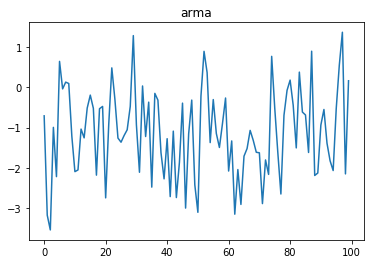

In [3]:
import ctsb
import jax.numpy as np
import matplotlib.pyplot as plt

T = 100
p, q = 3, 3
problem = ctsb.problem("ARMA-v0")
problem.initialize(p,q)
test_output = []
for t in range(T):
    test_output.append(problem.step())

info = problem.hidden()
print("info: " + str(info))

plt.plot(test_output)
plt.title("arma")
plt.show(block=False)


The help() method provides more info about the API of a certain Problem class.

In [0]:
problem.help()

# The Model Class
The Model class is the abstraction used to implement models/predictors for the problems. CTSB is designed so that the Model and Problem classes can be combined in a modular fashion. Roughly speaking, the goal of CTSB is to be able to test an arbitrary model on an arbitrary problem, at least when it makes sense to do so. For example, below we show how to combine a basic last-value model (a predictor that just outputs the previous observation) for time series on the ARMA problem.

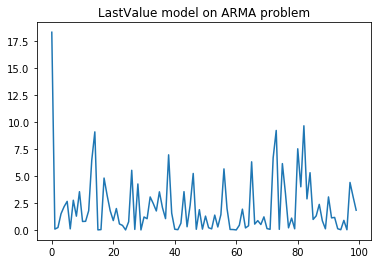

In [0]:
import ctsb
import jax.numpy as np
import matplotlib.pyplot as plt

T = 100
p, q = 3, 3
problem = ctsb.problem("ARMA-v0")
cur_x = problem.initialize(p, q)
model = ctsb.model("LastValue")
model.initialize()
loss = lambda y_true, y_pred: (y_true - y_pred)**2

results = []
for i in range(T):
    cur_y_pred = model.predict(cur_x)
    cur_y_true = problem.step()
    cur_loss = loss(cur_y_true, cur_y_pred)
    results.append(cur_loss)
    model.update(cur_loss)
    cur_x = cur_y_true

plt.plot(results)
plt.title("LastValue model on ARMA problem")
plt.show(block=False)


# The Problem and Model Registry
Each of the Problem and Model classes included in CTSB are inserted into a global registry, which is dict from a unique string to the Problem/Model class corresponding to the string. The registry supports versioning, so that multiple versions of a certain Problem/Model can be referenced. For example, the id "ARMA-v0" is the registry id for version 0 of the ARMA problem. The previous example shows how to create instances of problem and model via the corresponding registry ids. A comprehensive list of all Problem and Model ids can be printed by printing out the keys of the global registries: problem_registry and model_registry, as demonstrated below.

In [0]:
print(ctsb.problem_registry.keys())
print(ctsb.model_registry.keys())

dict_keys(['Random-v0', 'ARMA-v0', 'LDS-v0', 'RNN-v0', 'LSTM-v0', 'SP500-v0', 'UCIIndoor-v0', 'Crypto-v0'])
dict_keys(['LastValue', 'Linear', 'PredictZero', 'KalmanFilter'])


# The Experiment Class
The EXperiment class should be thought of as a sort of engine that allows the automated combination of various models against various problems. The initialize method supports two types of operation: single problem experiments and multi-problem experiments. A single problem experiment is defined when calling initialize by specifying: a loss function, a single Problem identifed by a unique string in the Problem registry, a dict of problem parameters, and a list of Models identified by unique strings in the Model Registry. We demonstrate how to create a single Problem experiment below.

  1%|          | 1/100 [00:00<00:11,  8.31it/s]

running experiment: <LastValue Model> on <ARMA Problem>


  1%|          | 1/100 [00:00<00:09,  9.96it/s]

running experiment: <PredictZero Model> on <ARMA Problem>


100%|██████████| 100/100 [00:10<00:00,  9.20it/s]


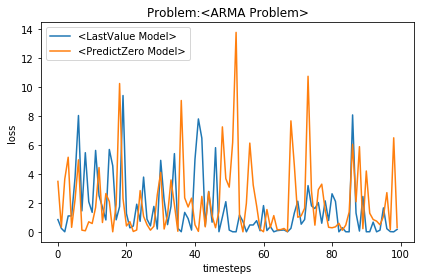

In [17]:
import ctsb
from ctsb.problems.time_series import Crypto
from ctsb.problems.control.arma import ARMA
from ctsb.models.time_series.last_value import LastValue
from ctsb.models.time_series.predict_zero import PredictZero
from ctsb.utils.experiment import Experiment
import jax.numpy as np
import matplotlib.pyplot as plt

exp = Experiment()
MSE = lambda y_true, y_pred: (y_true - y_pred)**2
exp.initialize(MSE, problem_id="ARMA-v0", problem_params={'p': 3, 'q':3}, model_id_list=['LastValue', 'PredictZero'])
steps = 100
exp.run_all_experiments(steps)
exp.plot_all_problem_results()


A multi-problem experiment is defined when calling initialize by specifying: a loss function, and a dict whose keys are problem ids, and whose values are tuples of the form (dict of model params, list of model ids). We demonstrate how to create a multi-problem experiment below.

  1%|          | 1/100 [00:00<00:10,  9.56it/s]

running experiment: <LastValue Model> on <ARMA Problem>


  1%|          | 1/100 [00:00<00:11,  8.85it/s]

running experiment: <PredictZero Model> on <ARMA Problem>


100%|██████████| 100/100 [00:00<00:00, 30275.04it/s]


running experiment: <LastValue Model> on <SP500<SP500-v0>> call object help() method for info
running experiment: <PredictZero Model> on <SP500<SP500-v0>> call object help() method for info


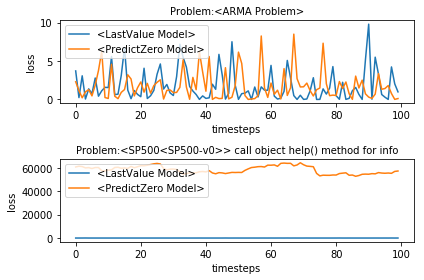

In [18]:
exp = Experiment()
MSE = lambda y_true, y_pred: (y_true - y_pred)**2
model_id_list = ['LastValue', 'PredictZero']
exp.initialize(MSE, problem_to_param_models={'ARMA-v0' : ({'p':3, 'q':3}, model_id_list), 
                                              'SP500-v0' : ({}, model_id_list)
                                            }
              )
steps = 100
exp.run_all_experiments(steps)
exp.plot_all_problem_results()

# Random Seeding
Many of the problems/models utilize randomness implemented by jax.random. In order to enforce reproducibility of experiment results, we seed a global random key when ctsb is imported. When jax.random functions are called, we leverage auxiliary functions in ctsb.utils.random to generate new random keys on the fly based on the current global random key. Below, we demonstrate how to reproduce the same experiment twice by calling set_key().

In [0]:
import jax.numpy as np
import jax.random as random
import ctsb
import matplotlib.pyplot as plt
from ctsb.problems.control.lds import LDS
from ctsb.utils.random import generate_key, set_key

T = 100
n, m, d = 5, 1, 10
problem = ctsb.problem("LDS-v0")

set_key(0)
problem.initialize(n, m, d)
test_output = []
for t in range(T):
    u = random.normal(generate_key(),shape=(n,))
    test_output.append(problem.step(u))

set_key(0)
problem.initialize(n, m, d)
test_output_2 = []
for t in range(T):
    u = random.normal(generate_key(),shape=(n,))
    test_output_2.append(problem.step(u))

fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(test_output)
ax[1].plot(test_output_2)

fig.tight_layout()
plt.show()